In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [3]:
mydata = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
mydata.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [6]:
# weight of evidence transformer
import category_encoders as ce

In [40]:
# woe of 5 bins
woe = ce.WOEEncoder(cols=["rank"], drop_invariant=True)
woe.fit(mydata, mydata["admit"])
mydata_woe = woe.transform(mydata)
mydata_woe.head()

,admit,gre,gpa,rank
0,0,380,3.61,-0.419040
1,1,660,3.67,-0.419040
2,1,800,4.00,0.916023
3,1,640,3.19,-0.703444
4,0,520,2.93,-0.703444


In [41]:
mydata_woe["rank"].value_counts()

rank
 0.179324    151
-0.419040    121
-0.703444     67
 0.916023     61
Name: count, dtype: int64

In [42]:
# discretize the gre
mydata_woe["gre"] = pd.cut(mydata_woe["gre"], 5)
woe = ce.WOEEncoder(cols=["gre"], drop_invariant=True)
woe.fit(mydata_woe, mydata_woe["admit"])
mydata_woe = woe.transform(mydata_woe)
mydata_woe.head()

,admit,gre,gpa,rank
0,0,-1.140161,3.61,-0.419040
1,1,0.192066,3.67,-0.419040
2,1,0.330874,4.00,0.916023
3,1,0.192066,3.19,-0.703444
4,0,-0.105265,2.93,-0.703444


In [67]:
X = mydata_woe[["gre", "rank"]]
X = sm.add_constant(X)
y = mydata["admit"]

In [68]:
lm = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.580181
         Iterations 6


In [69]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Wed, 08 Nov 2023   Pseudo R-squ.:                 0.07167
Time:                        21:45:05   Log-Likelihood:                -232.07
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 1.657e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7929      0.114     -6.937      0.000      -1.017      -0.569
gre            0.9961      0.332      3.002      0.003       0.346       1.646
rank           0.9921      0.215      4.614      0.000       0.571       1.414
==============================================================================
"""

The logistic regression estimation results are interpreted as follows:

const: This is the constant, also known as the intercept. It's the log odds of the outcome when all predictor variables are zero. In this case, the constant is -0.7929, and the p-value is 0.000, which is less than 0.05. This suggests that the constant is significantly different from zero.

gre: This is the coefficient for the gre predictor variable. It suggests that for each unit increase in gre, the log odds of the outcome increase by 0.9961. The p-value is 0.003, which is less than 0.05, indicating that gre is a significant predictor in the model.

rank: This is the coefficient for the rank predictor variable. It suggests that for each unit increase in rank, the log odds of the outcome increase by 0.9921. The p-value is 0.000, which is less than 0.05, indicating that rank is a significant predictor in the model.

The standard errors, z-statistics, and confidence intervals provide additional information about the precision and significance of these estimates.

In [73]:
const, b1, b2 = lm.params
const, b1, b2

(-0.7929063786633203, 0.9960638277665781, 0.9920986975639382)

In [82]:
# add mdoel score column
scored = mydata_woe.copy()
scored["score"] = const + b1 * scored["gre"] + b2 * scored["rank"]
scored["pred_admit_rate"] = lm.predict(X)
scored.head()

,admit,gre,gpa,rank,score,pred_admit_rate
0,0,-1.140161,3.61,-0.419040,-2.344309,0.087519
1,1,0.192066,3.67,-0.419040,-1.017326,0.265549
2,1,0.330874,4.00,0.916023,0.445451,0.609557
3,1,0.192066,3.19,-0.703444,-1.299482,0.214252
4,0,-0.105265,2.93,-0.703444,-1.595642,0.168592


In [83]:
# scale
avg_admit_rate = scored["admit"].mean()
print(avg_admit_rate)

0.3175


In [84]:
base_points = 600
base_odds = avg_admit_rate / (1 - avg_admit_rate)
pdo = 20

factor = pdo / np.log(2)
offset = base_points - (factor * np.log(base_odds))
print(factor, offset)
scored["score_scaled"] = scored["score"] * factor + offset
scored.head()

28.85390081777927 622.0814490829538


,admit,gre,gpa,rank,score,pred_admit_rate,score_scaled
0,0,-1.140161,3.61,-0.419040,-2.344309,0.087519,554.438987
1,1,0.192066,3.67,-0.419040,-1.017326,0.265549,592.727630
2,1,0.330874,4.00,0.916023,0.445451,0.609557,634.934452
3,1,0.192066,3.19,-0.703444,-1.299482,0.214252,584.586323
4,0,-0.105265,2.93,-0.703444,-1.595642,0.168592,576.040942


In [85]:
# score card
score_gre = scored["gre"].unique()
score_gre = score_gre * b1 * factor
score_gre

array([-32.76860823,   5.52003526,   9.50943549,  -3.02534526,
         1.83396374])

In [86]:
score_rank = scored["rank"].unique()
score_rank = score_rank * b2 * factor
score_rank

array([-11.99541185,  26.22200986, -20.13671955,   5.13332546])

In [98]:
a_score = -1.140161 * b1 + -0.419040 * b2 + const
print(a_score)
a_scaled_score = a_score * factor + offset
print(a_scaled_score)
a_odds = np.exp(a_score)
print(a_odds)
a_pd = a_odds / (1 + a_odds)
print(a_pd)
a_scaled_odds = np.exp((a_scaled_score - offset) / factor)
print(a_scaled_odds)

-2.3443085468206823
554.4390027867175
0.09591349890105548
0.08751922391432741
0.09591349890105538


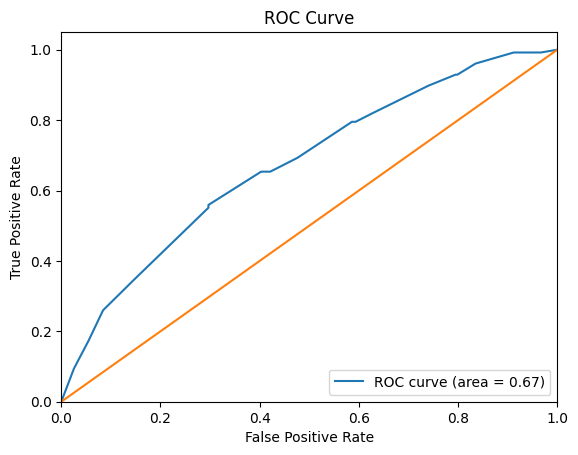

In [53]:
# roc curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, lm.predict(X))
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Axes: xlabel='gre', ylabel='rank'>

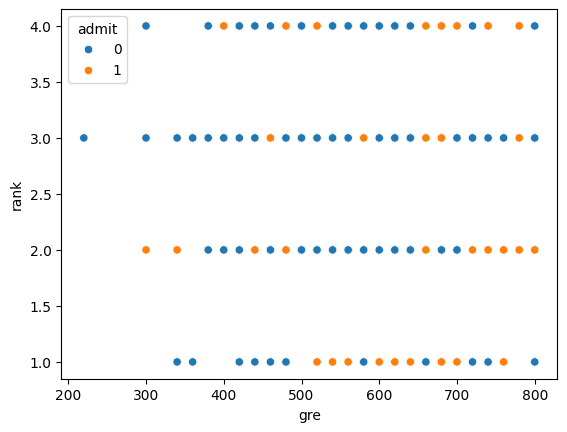

In [52]:
# plot variable chart
import seaborn as sns

sns.scatterplot(x="gre", y="rank", hue="admit", data=mydata)